https://github.com/mjpyeon/wavenet-classifier/blob/master/WaveNetClassifier.py

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [1]:
# Needed to allow editing using PyCharm etc
%load_ext autoreload
%autoreload 2

The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [2]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks\\wavenet':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/processed/wavenet/processed.pkl'
    
from src.data import load_data
from src.visualization import multiple_plots, visualize, plot_confusion_matrix
from src.features import make_spectrograms, process_labels, make_directory

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
from matplotlib import colors
from scipy.signal import butter, freqz, lfilter, spectrogram
import time
from sklearn import preprocessing

Import remaining packages

In [4]:
import numpy as np
import sys
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
import sys
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.models import load_model
import pickle

Using TensorFlow backend.


In [5]:
# wavenet imports
import pandas as pd
import sys
import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Activation, Dropout, Add, TimeDistributed, Multiply, Conv1D, Conv2D, MaxPooling1D, AveragePooling1D
from keras.models import Model, Sequential, load_model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import History, ModelCheckpoint
from keras.layers import Conv1D, Input, Activation, AveragePooling1D, Add, Multiply, GlobalAveragePooling1D


In [6]:
with open(DATA_PATH, "rb") as file:
    data = pickle.load(file)

In [7]:
def convert_label_to_int(label):
    if label == "walking":
        return 0
    if label == "pushing":
        return 1
    if label == "sitting":
        return 2
    if label == "pulling":
        return 3
    if label == "circling":
        return 4
    if label == "clapping":
        return 5
    if label == "bending":
        return 6

In [9]:
train_x = []
train_y = []
test_x = []
test_y = []
test_user = "A"
for user_letter, actions in data.items():
    for action, results in actions.items():
        for result in results:
            for row in result:
                if user_letter == test_user:
                    test_x.append(row)
                    test_y.append(convert_label_to_int(action))
                else:
                    train_x.append(row)
                    train_y.append(convert_label_to_int(action)) 
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)      

In [10]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)
# batch_size = 100
# nb_epoch = 100

# input image dimensions
# img_rows, img_cols = 75, 75

In [11]:
train_y = np_utils.to_categorical(train_y, nb_classes)
test_y = np_utils.to_categorical(test_y, nb_classes)

In [12]:
train_x = abs(train_x)
test_x = abs(test_x)

In [13]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(3705, 200, 300)
(3705, 7)
(798, 200, 300)
(798, 7)


In [14]:
# reduce data amount
train_x = train_x[:500,:,:]
train_y = train_y[:500,:]

In [15]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(500, 200, 300)
(500, 7)
(798, 200, 300)
(798, 7)


In [16]:
# need to normalize the data?

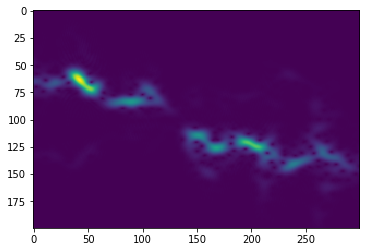

In [17]:
plt.imshow(abs(train_x[5]))

In [18]:
n_filters = 64
dilation_depth = 8
activation = 'softmax'
scale_ratio = 1
kernel_size = 2
pool_size_1 = 4
pool_size_2 = 8
batch_size = 4096
STROKE_COUNT = 196
TRAIN_SAMPLES = train_x.shape[0]
VALID_SAMPLES = test_x.shape[0]
TEST_SAMPLES = test_x.shape[0]

In [19]:
def residual_block(x, i):
    tanh_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal', 
                      name='dilated_conv_%d_tanh' % (kernel_size ** i), 
                      activation='tanh'
                      )(x)
    sigm_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal', 
                      name='dilated_conv_%d_sigm' % (kernel_size ** i), 
                      activation='sigmoid'
                      )(x)
    z = Multiply(name='gated_activation_%d' % (i))([tanh_out, sigm_out])
    skip = Conv1D(n_filters, 1, name='skip_%d'%(i))(z)
    res = Add(name='residual_block_%d' % (i))([skip, x])
    return res, skip

In [20]:
input_shape = train_x.shape[1:]
output_shape = train_y.shape[1:]

In [21]:
x = Input(shape=input_shape, name='original_input')

In [22]:
skip_connections = []
out = Conv1D(n_filters, 2, dilation_rate=1, padding='causal', name='dilated_conv_1')(x)
for i in range(1, dilation_depth + 1):
    out, skip = residual_block(out,i)
    skip_connections.append(skip)
out = Add(name='skip_connections')(skip_connections)
out = Activation('relu')(out)

In [23]:
out = Conv1D(n_filters, pool_size_1, strides = 1, padding='same', name='conv_5ms', activation = 'relu')(out)
out = AveragePooling1D(pool_size_1, padding='same', name='downsample_to_200Hz')(out)

In [24]:
out = Conv1D(n_filters, pool_size_2, padding='same', activation='relu', name='conv_500ms')(out)
out = Conv1D(output_shape[0], pool_size_2, padding='same', activation='relu', name='conv_500ms_target_shape')(out)
out = AveragePooling1D(pool_size_2, padding='same',name = 'downsample_to_2Hz')(out)
out = Conv1D(output_shape[0], (int) (input_shape[0] / (pool_size_1*pool_size_2)), padding='same', name='final_conv')(out)
out = GlobalAveragePooling1D(name='final_pooling')(out)
out = Activation(activation, name='final_activation')(out)

stroke_read_model = Model(x, out)  
stroke_read_model.compile(optimizer='adam', 
                          loss='categorical_crossentropy', 
                          metrics=['accuracy'])
stroke_read_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
original_input (InputLayer)     (None, 200, 300)     0                                            
__________________________________________________________________________________________________
dilated_conv_1 (Conv1D)         (None, 200, 64)      38464       original_input[0][0]             
__________________________________________________________________________________________________
dilated_conv_2_tanh (Conv1D)    (None, 200, 64)      8256        dilated_conv_1[0][0]             
__________________________________________________________________________________________________
dilated_conv_2_sigm (Conv1D)    (None, 200, 64)      8256        dilated_conv_1[0][0]             
__________________________________________________________________________________________________
gated_acti

In [25]:
history = stroke_read_model.fit(train_x, train_y,
                      validation_data = (test_x, test_y), 
                      batch_size = batch_size,
                      epochs = 50)

Train on 500 samples, validate on 798 samples
Epoch 1/50
500/500 [==============================] - 17s 35ms/step - loss: 1.8918 - acc: 0.2180 - val_loss: 2.2069 - val_acc: 0.1429
Epoch 2/50
500/500 [==============================] - 5s 9ms/step - loss: 1.7150 - acc: 0.2280 - val_loss: 2.4530 - val_acc: 0.1429
Epoch 3/50
500/500 [==============================] - 5s 9ms/step - loss: 1.6523 - acc: 0.2280 - val_loss: 2.5508 - val_acc: 0.1441
Epoch 4/50
500/500 [==============================] - 4s 9ms/step - loss: 1.6036 - acc: 0.2280 - val_loss: 2.5529 - val_acc: 0.1729
Epoch 5/50
500/500 [==============================] - 4s 9ms/step - loss: 1.5644 - acc: 0.3080 - val_loss: 2.5488 - val_acc: 0.2519
Epoch 6/50
500/500 [==============================] - 5s 9ms/step - loss: 1.5215 - acc: 0.4800 - val_loss: 2.6086 - val_acc: 0.1830
Epoch 7/50
500/500 [==============================] - 5s 9ms/step - loss: 1.4940 - acc: 0.3520 - val_loss: 2.6529 - val_acc: 0.2619
Epoch 8/50
500/500 [========

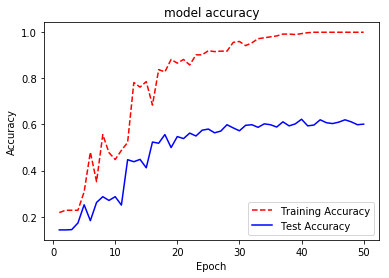

In [29]:
visualize.plot_train_test_acc(history=history)